In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from model import *

In [2]:
import pandas as pd 

df = pd.read_csv("prices_all_5m.csv")
n = len(df)
startingRow = 0


In [15]:
#paramaters for SIMULATION

# APY's
lendRate = .00
borrowRate = .00
farmRate = .4

#SIM INFO
stepsPerYear = 365*24*12 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'farm' : farmRate}
adjRates = {'lend' : ((1 + lendRate)**(1/stepsPerYear) - 1), 
            'borrow' : ((1 + borrowRate)**(1/stepsPerYear) - 1),
            'farm' : (farmRate / stepsPerYear)}



In [16]:
#SIM HELPERS
def setInitialValues() :
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    return vol1, vol2, lp, vaultInitial

def genSimulatedTrades() : 
    allTrades = []

    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)
    return allTrades

def simStats(vaultTVL, vaultLog) : 
    apy = (vaultLog[-1] / vaultTVL)**(stepsPerYear / nSteps) - 1
    dradown = 0
    prevMax = vaultTVL
    for i in range(len(vaultLog)) : 
        prevMax = max(prevMax, vaultLog[i])
        drawdownT = 1 - vaultLog[i] / prevMax
        drawdown = max(dradown, drawdownT)
    return apy, drawdown


In [51]:
vaultTVL = 1000.
lendAllocation = .5
vaultToken = 'USDC'
secondaryToken = 'ETH'
startingRow = 0
startingPrice = df['Close_' + secondaryToken][startingRow]
#LP Size 
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1 / startingPrice #amount of secondary token in LP

priceData = list(df['Close_' + secondaryToken][startingRow:])

debtLow = .97
debtHigh = 1.03

collatLow = .5
collatTarget = 1
collatHigh = 1.5

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulateMarket(priceData, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates,
                                                            collatLow = collatLow, collatTarget = collatTarget, collatHigh = collatHigh, 
                                                            debtLow = debtLow, debtHigh = debtHigh)
vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1, vol1, vol2 = simulateMarket(priceData, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates,
                                                            collatLow = collatLow, collatTarget = collatTarget, collatHigh = collatHigh, 
                                                            debtLow = debtLow, debtHigh = debtHigh, rebalance = False)

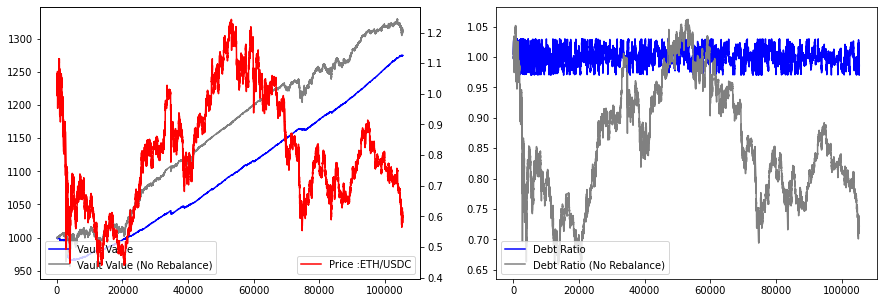

In [52]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value (No Rebalance)' )

ax.legend(loc = 'lower left')
ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price :' + secondaryToken + "/" + vaultToken)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend(loc = 'lower right')

ax = fig.add_subplot(1, 2, 2)

ax.plot(debtRatioLog, color = 'blue', label = 'Debt Ratio' )
ax.plot(debtRatioLog1, color = 'grey', label = 'Debt Ratio (No Rebalance)' )
ax.legend(loc = 'lower left')

plt.show()


In [53]:
vaultTVL = 1000.
lendAllocation = .5
vaultToken = 'USDC'
secondaryToken = 'ETH'
startingRow = 0
startingPrice = df['Close_' + secondaryToken][startingRow]
#LP Size 
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1 / startingPrice #amount of secondary token in LP

priceData = list(df['Close_' + secondaryToken][startingRow:])

In [54]:
import random

In [55]:
#how many points per simulation 
nPoints = 24*12*90
maxStartingPoint = len(df) - nPoints
nSims = 5 

In [56]:
#Here we take random intervals of 3 months 
#and Simulate strategy performance with different debt ratio thresholds for rebalancing 

drDiff = 0.01 
nDebtRatios = 30 

apyLog = []
drDiffLog = []

for j in range(nSims) :
    startInd = random.randint(0, maxStartingPoint)
    endInd = startInd + nPoints
    priceData = list(df['Close_' + secondaryToken][startInd:endInd])
    for i in range(nDebtRatios) : 
        debtLow = 1 - (i+1)*drDiff
        debtHigh = 1 + (i+1)*drDiff

        vol1, vol2, lp, vaultInitial = setInitialValues()
        vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulateMarket(priceData, vaultInitial, lp, vaultToken, 
                                                                    secondaryToken, vol1, vol2, adjRates,
                                                                    collatLow = collatLow, collatTarget = collatTarget, collatHigh = collatHigh, 
                                                                    debtLow = debtLow, debtHigh = debtHigh)    

        APY = ((vaultLog[-1] / vaultTVL) ** (len(priceData) / stepsPerYear) - 1)

        apyLog.append(APY)
        drDiffLog.append((i+1)*drDiff)
    

Text(0.5, 1.0, 'APY vs Debt Ratio Width')

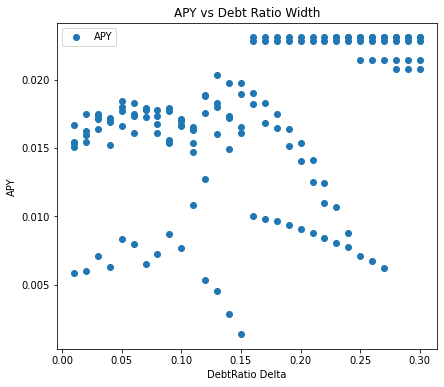

In [57]:
#IL Illuimport matplotlib.ticker as mtick
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,6)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('APY')
ax.set_xlabel('DebtRatio Delta')
plt.scatter(drDiffLog, apyLog, label = "APY")
plt.legend(loc = 'upper left')
plt.title("APY vs Debt Ratio Width")